To start, we run the "shared libraries" Jupyter notebook we've created for this project. 

This imports all the libraries we need including pandas, numpy, etc.

It also imports the datasets studied, as well as the foundational dataframes we've created from that set as part of this discovery process:


In [3]:
# Importing shared libraries, functions, and data frames
%run 'shared_libraries_functions_dataframes.ipynb'

The first data frame of interest to us is 'core\_deaths', which filters out the unused columns from the primary data set. 

It also drops the summary rows that skew data visualization and calculations \- summary rows for all causes of death, as well as totals across all states are thus removed.  
When needed, we can easily calculate those numbers simply by counting the totals across causes of death or states.

Here is what 'core\_deaths' looks like with those items removed:


In [4]:
# Viewing the first few rows of the dataset
core_deaths.head()

,Year,Cause Name,State,Deaths,Age-adjusted Death Rate
1,2017,Unintentional injuries,Alabama,2703,53.8
2,2017,Unintentional injuries,Alaska,436,63.7
3,2017,Unintentional injuries,Arizona,4184,56.2
4,2017,Unintentional injuries,Arkansas,1625,51.8
5,2017,Unintentional injuries,California,13840,33.2


Now that we have a clean data frame, we can visualize the leading causes of death per state and their numbers.

For our initial visualization, we'll look at this data for the most recent year captured in the dataset \(2017\):



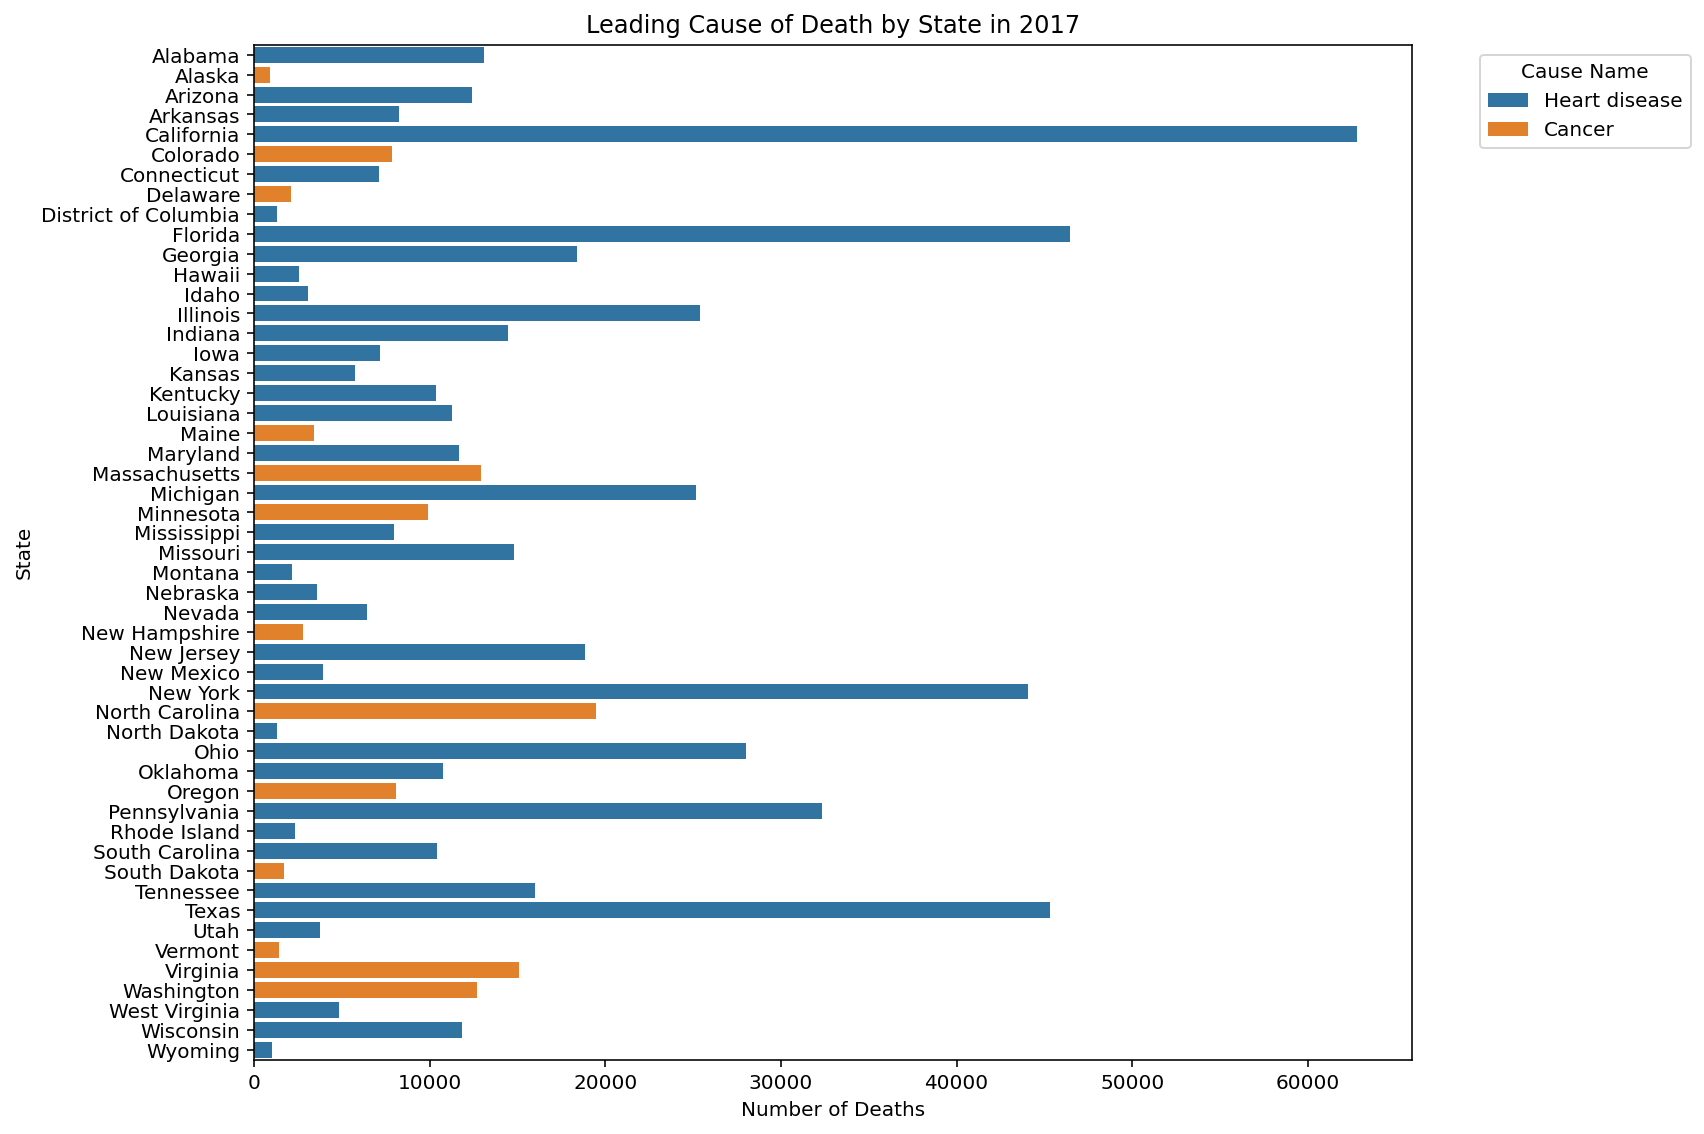

In [5]:
# Creating a visualization of deaths by state for the most recent year (2017)

# Filtering for the most recent year
recent_year = core_deaths['Year'].max()
causes_recent = core_deaths[core_deaths['Year'] == recent_year]

# Grouping by 'State' and 'Cause Name', and summing up the 'Deaths'
state_cause_deaths = causes_recent.groupby(['State', 'Cause Name'])['Deaths'].sum().reset_index()

# Determining the leading cause of death for each state
idx = state_cause_deaths.groupby('State')['Deaths'].idxmax()
leading_causes = state_cause_deaths.loc[idx]

# Setting the figure size
plt.figure(figsize=(12, 8))

# Creating a bar plot
sns.barplot(data=leading_causes, x='Deaths', y='State', hue='Cause Name', dodge=False)

# Adding titles and labels
plt.title(f'Leading Cause of Death by State in {recent_year}')
plt.xlabel('Number of Deaths')
plt.ylabel('State')

# Displaying the legend outside the plot
plt.legend(title='Cause Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Showing the plot
plt.tight_layout()
plt.show()

We can also indentify what are he most significant causes of deaths across all states combined, to get an idea of the proportions we're looking at:

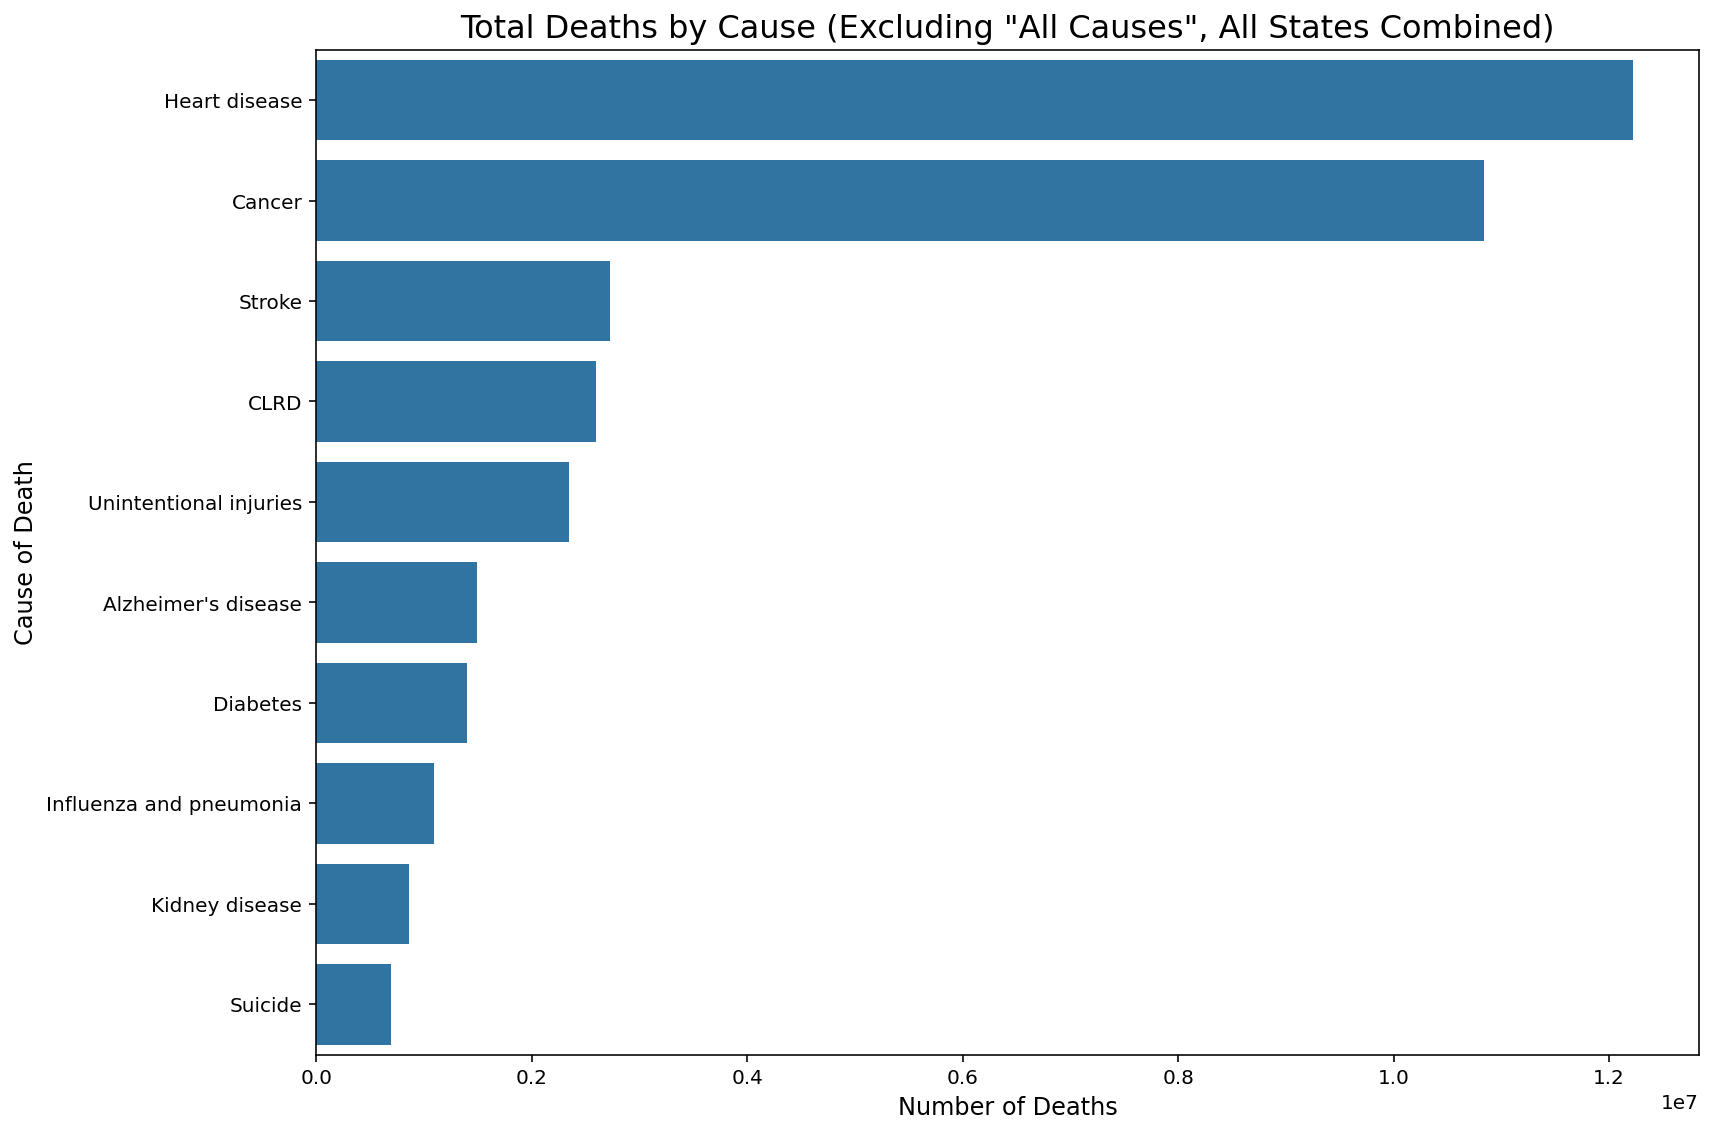

In [6]:
# Visualizing the causes of death to identify the most significant causes

# Aggregating deaths by cause
cause_deaths = core_deaths.groupby('Cause Name')['Deaths'].sum().reset_index()

# Sorting by the number of deaths
cause_deaths = cause_deaths.sort_values(by='Deaths', ascending=False)

# Handling missing data (depending on context)
cause_deaths = cause_deaths.dropna()  # Remove any rows with NaN values

# Plotting the data
plt.figure(figsize=(12, 8))
sns.barplot(data=cause_deaths, x='Deaths', y='Cause Name')

# Adding titles and labels
plt.title('Total Deaths by Cause (Excluding "All Causes", All States Combined)', fontsize=16)
plt.xlabel('Number of Deaths', fontsize=12)
plt.ylabel('Cause of Death', fontsize=12)

# Displaying the plot
plt.tight_layout()
plt.show()

This breakdown is very interesting, with Heart Disease and Cancer leading all other causes combined by a significant margin.

This led us to the question of how the number of deaths for these causes is evolving over the years: are advances in medicine and health significantly reducing the number of deaths?

To figure this out, we looked at the same data again, but visualized it's evolution across the all years captured in the data set \(1999 to 2017\):


<Figure size 1008x576 with 0 Axes>

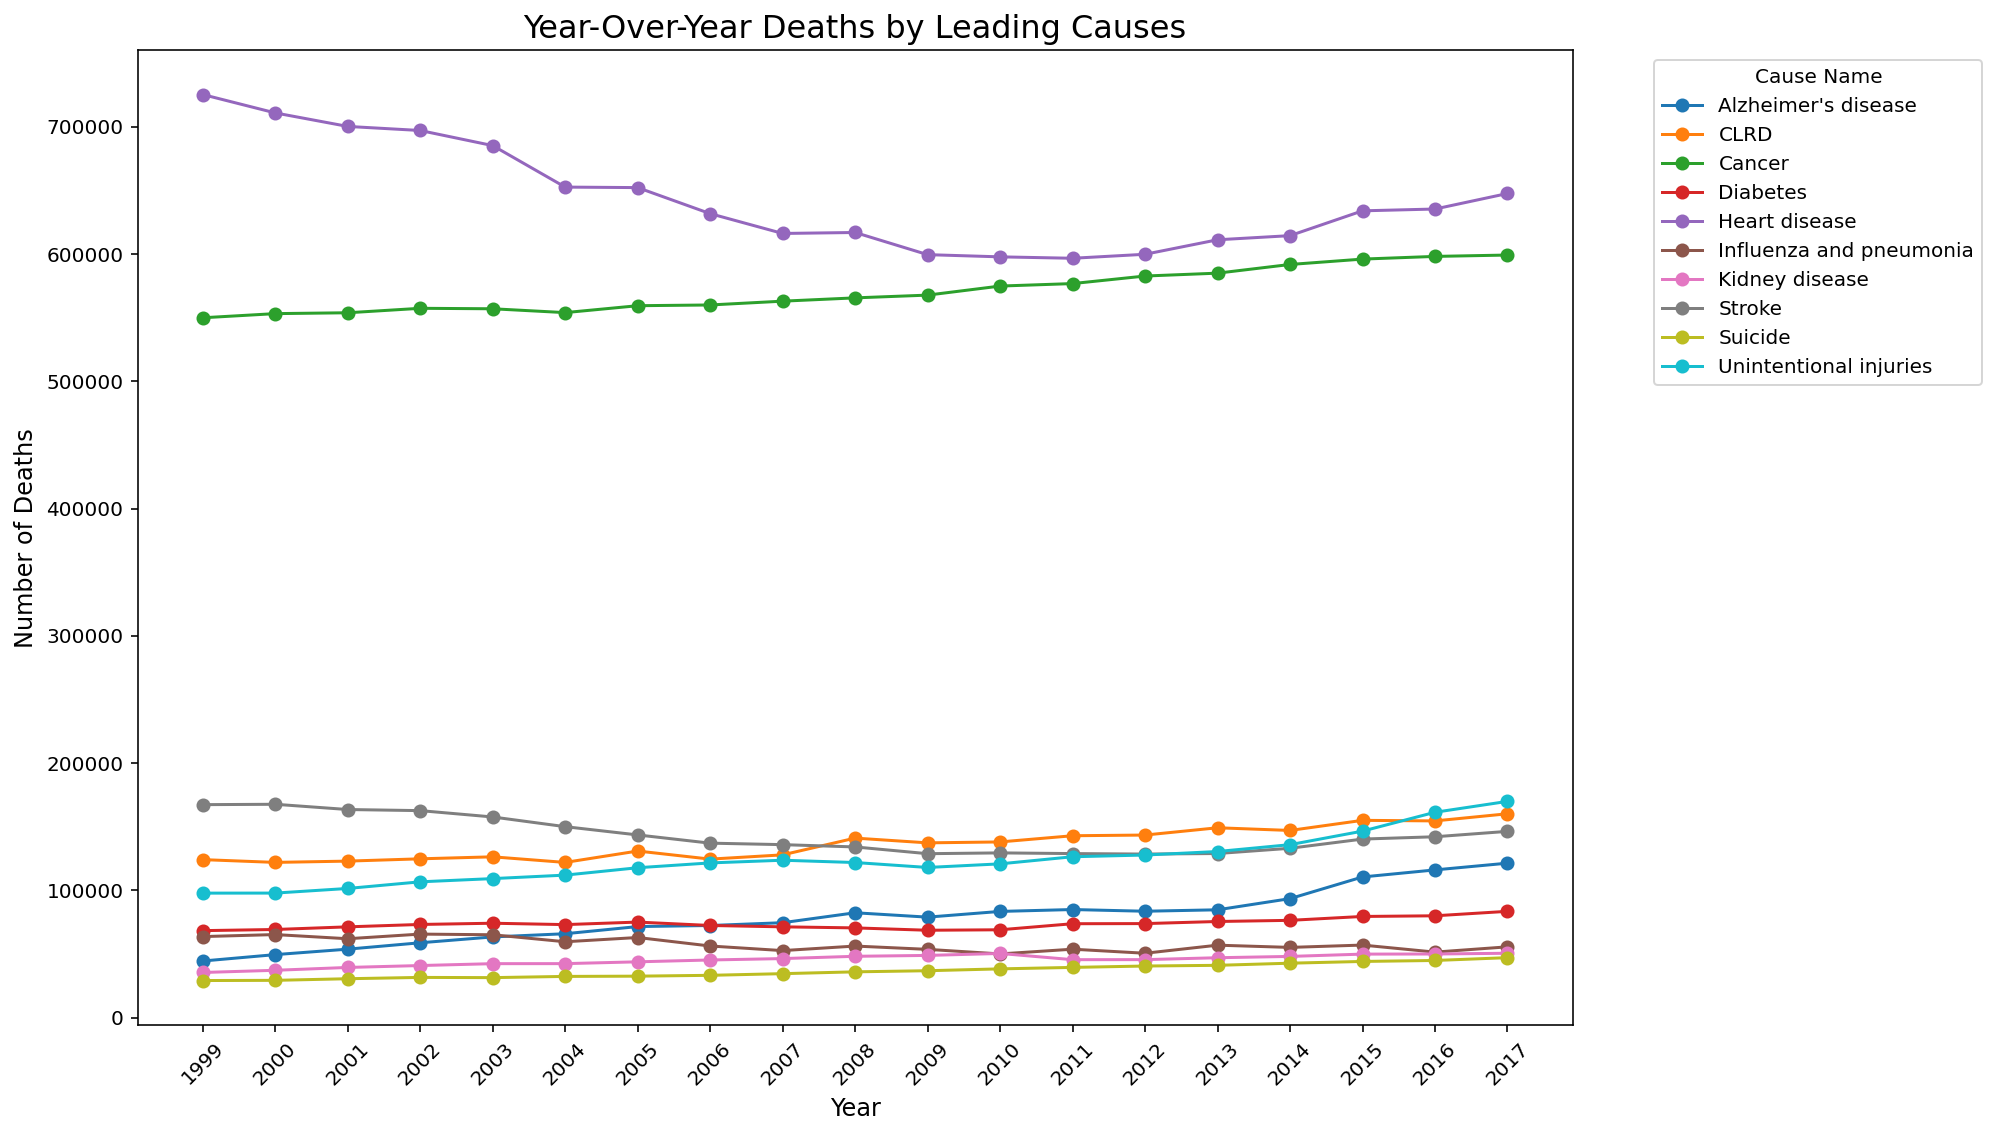

In [7]:
# Visualizing the number of deaths over time, to track their evolution.

# Aggregating deaths by year and cause
yearly_cause_deaths = core_deaths.groupby(['Year', 'Cause Name'])['Deaths'].sum().reset_index()

# Sorting causes by total deaths across all years for better visualization
top_causes = yearly_cause_deaths.groupby('Cause Name')['Deaths'].sum().nlargest(10).index
yearly_cause_deaths = yearly_cause_deaths[yearly_cause_deaths['Cause Name'].isin(top_causes)]

# Pivoting data for line plot
pivot_data = yearly_cause_deaths.pivot(index='Year', columns='Cause Name', values='Deaths')

# Plotting the data
plt.figure(figsize=(14, 8))
pivot_data.plot(kind='line', marker='o', figsize=(14, 8))

# Adding titles and labels
plt.title('Year-Over-Year Deaths by Leading Causes', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Deaths', fontsize=12)
plt.xticks(ticks=pivot_data.index, labels=pivot_data.index, rotation=45)  # Individual labels for each year
plt.legend(title='Cause Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.tight_layout()
plt.show()

This visualization yielded two large surprises:

1: The deaths for heart disease were clearly decreasing from 1999 to 2009, but then changed course and have been increasing ever since \(at least through 2017\)


2: Cancer deaths, as well as many of the lesser causes of death, have steadily been increasing across the entire time span studied.


This lead us to realize that to fully understand the data, we would need an additional data point not available in our initial data set: 

We would need to know how the population of the US evolved over the same time period, in order to understand if the overall percentages of death across the population were increasing or decreasing. 

We identified an additional data set with that information, and proceeded to create a data frame that would merge both sets of data, and extract percentages of the population that were dying from each cause of death:


In [8]:
# Now aggregating 'core_and_state_pops' deaths by year and cause
aggregate = core_and_state_pops.groupby(['Year', 'Cause Name'])[['Deaths', 'Population']].sum().reset_index()

# Calculating Death Percentages
aggregate['Death Percentage'] = (aggregate['Deaths'] / aggregate['Population']) * 100

aggregate.T

,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
Year,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0,1999.0,...,2017.0,2017.0,2017.0,2017.0,2017.0,2017.0,2017.0,2017.0,2017.0,2017.0
Cause Name,Alzheimer's disease,CLRD,Cancer,Diabetes,Heart disease,Influenza and pneumonia,Kidney disease,Stroke,Suicide,Unintentional injuries,...,Alzheimer's disease,CLRD,Cancer,Diabetes,Heart disease,Influenza and pneumonia,Kidney disease,Stroke,Suicide,Unintentional injuries
Deaths,44536,124181,549838,68399,725192,63730,35525,167366,29199,97860,...,121404,160201,599108,83564,647457,55672,50633,146383,47173,169936
Population,279040168,279040168,279040168,279040168,279040168,279040168,279040168,279040168,279040168,279040168,...,325719178,325719178,325719178,325719178,325719178,325719178,325719178,325719178,325719178,325719178
Death Percentage,0.01596,0.044503,0.197046,0.024512,0.259888,0.022839,0.012731,0.059979,0.010464,0.03507,...,0.037273,0.049184,0.183934,0.025655,0.198778,0.017092,0.015545,0.044941,0.014483,0.052173


Once this 'aggregate' data frame had been created, we were able to visualize the deaths by percentage of the population, rather than by total numbers.  

To set a visualization baseline, we started off by simply visualizing the population growth of the US over the time span studied:


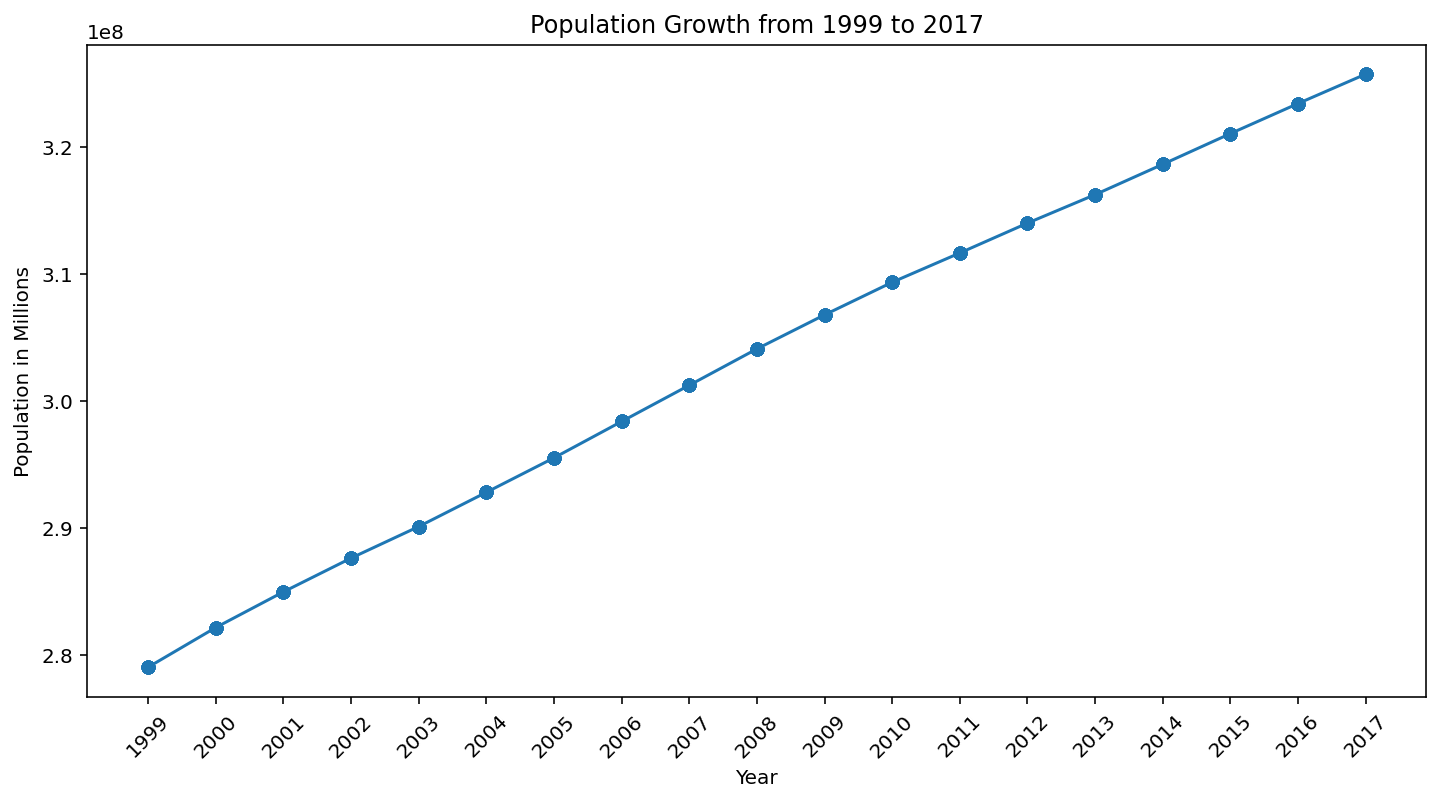

In [9]:
import matplotlib.pyplot as plt

# Now aggregating 'core_and_state_pops' deaths by year and cause
aggregate = core_and_state_pops.groupby(['Year', 'Cause Name'])[['Deaths', 'Population']].sum().reset_index()

# Filtering for the years 1999 to 2017
population_growth = aggregate[(aggregate['Year'] >= 1999) & (aggregate['Year'] <= 2017)]

# Plotting the population growth
plt.figure(figsize=(12, 6))
plt.plot(population_growth['Year'], population_growth['Population'], marker='o')
plt.title('Population Growth from 1999 to 2017')
plt.xlabel('Year')
plt.ylabel('Population in Millions')
plt.xticks(population_growth['Year'].unique(), rotation=45)
plt.show()

This visualization showed us that as expected, the US population had grown steadily during that time.  
What would this mean for our "cause of death" numbers?  

Once adjusted for population growth, would it show that all causes of death were actually decreasing over time?


To find out, we re\-ran our first visualization, but this time displaying the percentages rather than the raw numbers:


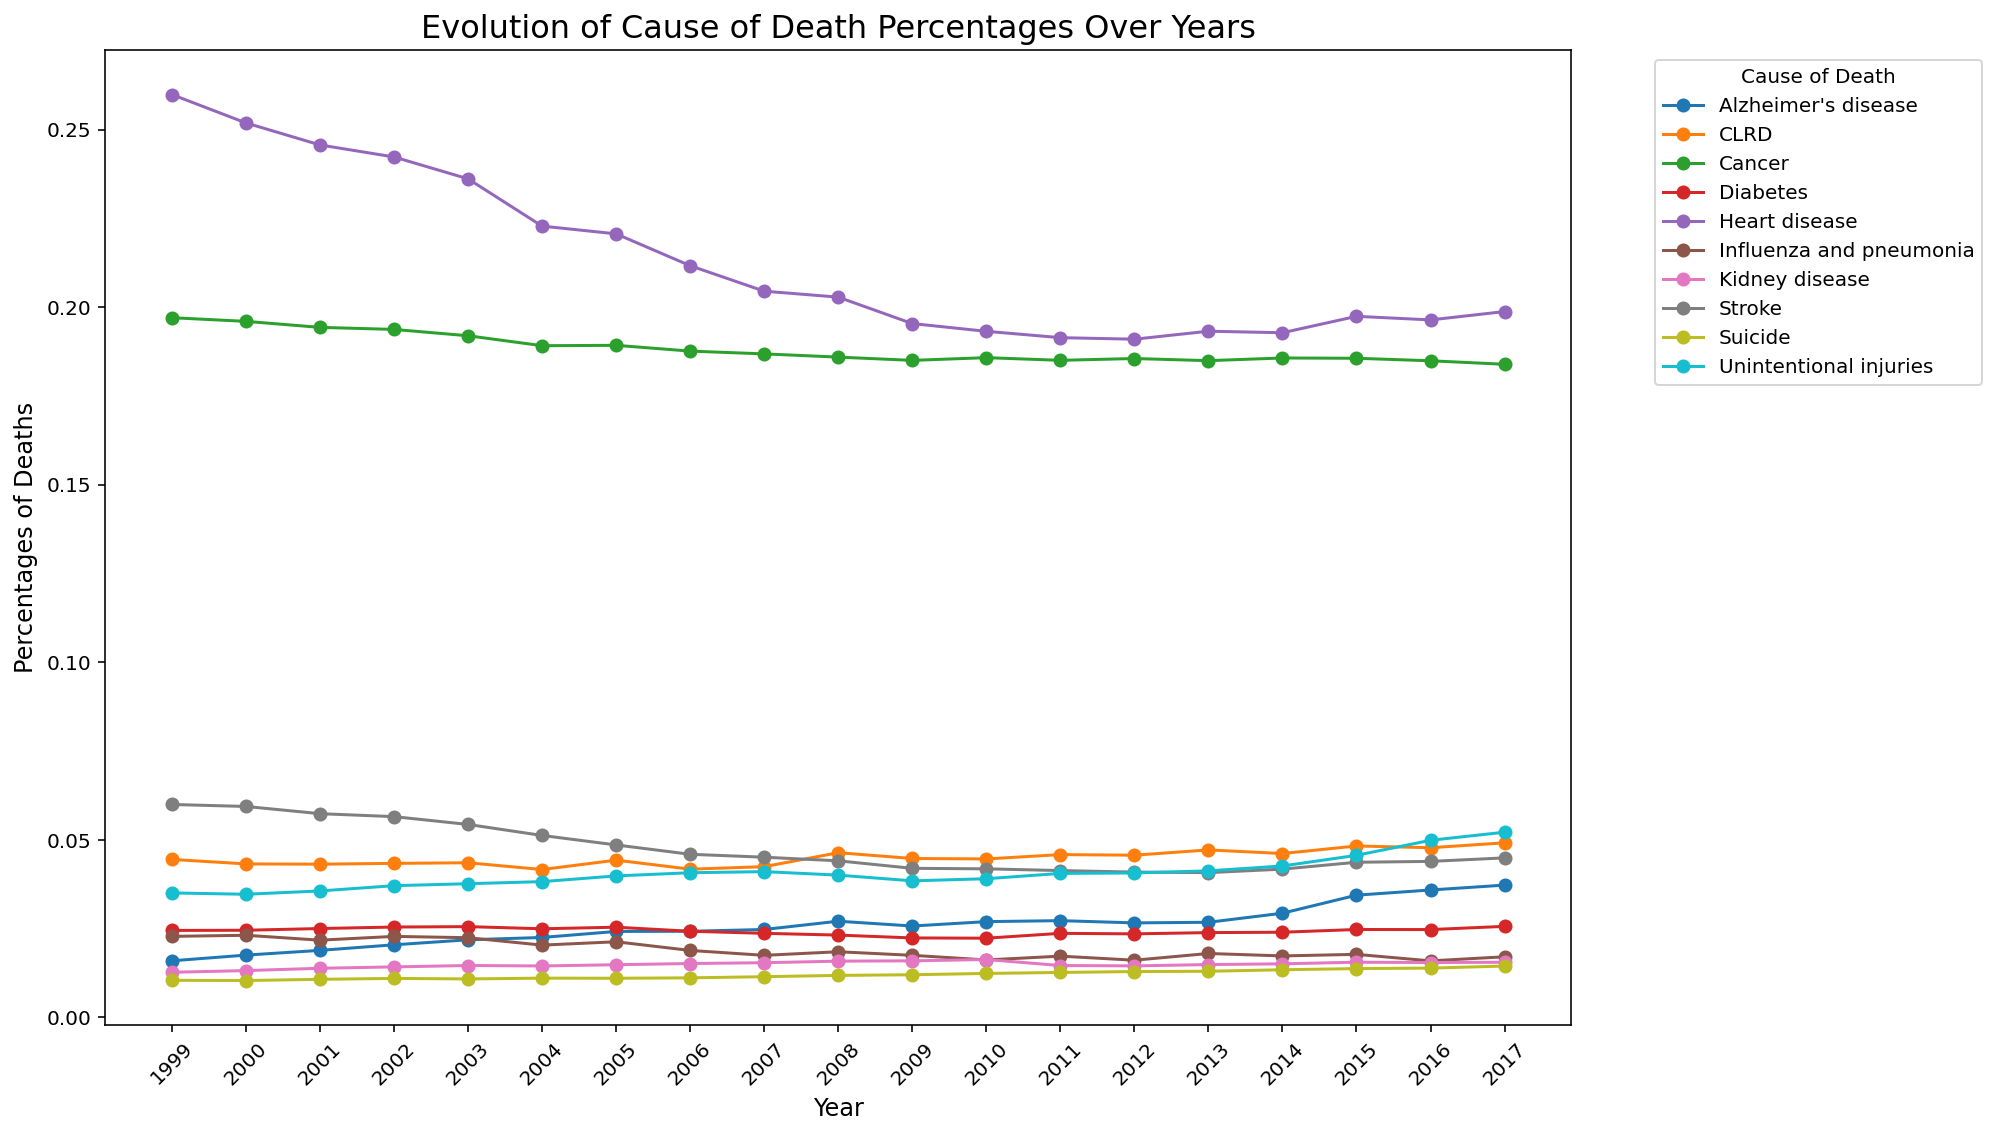

In [10]:
# Now aggregating 'core_and_state_pops' deaths by year and cause
aggregate = core_and_state_pops.groupby(['Year', 'Cause Name'
                                         ])[['Deaths', 'Population'
                                             ]].sum().reset_index()

# Calculating Death Percentages
aggregate['Death Percentage'] = (aggregate['Deaths'] /
                                 aggregate['Population']) * 100

# Pivoting the data for plotting
pivot_table = aggregate.pivot(index='Year',
                              columns='Cause Name',
                              values='Death Percentage')

# Plotting the evolution of cause of death percentages year over year
plt.figure(figsize=(14, 8))
for cause in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[cause], label=cause, marker='o')
plt.title('Evolution of Cause of Death Percentages Over Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentages of Deaths', fontsize=12)
plt.xticks(ticks=pivot_data.index, labels=pivot_data.index, rotation=45)  # Individual labels for each year
plt.legend(title='Cause of Death', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

As we had hoped, converting the numbers to percentages showed a much more encouaging trend, reversing the growth trend for Cancer to show a decline in deaths (by %).  
The hear disease numbers still show some growth since 2012, but it is less pronounced in this context.

**SIDE NOTE:** Percentages of Deaths are captured against the total population. Since only a small percent of the population dies each year, the death percentages combined only add up to a small % of the total population numbers.  


With this new information, we then wanted to identify what total percent of the US population actually dies every year.  
We visualized this data from our data set as follows:

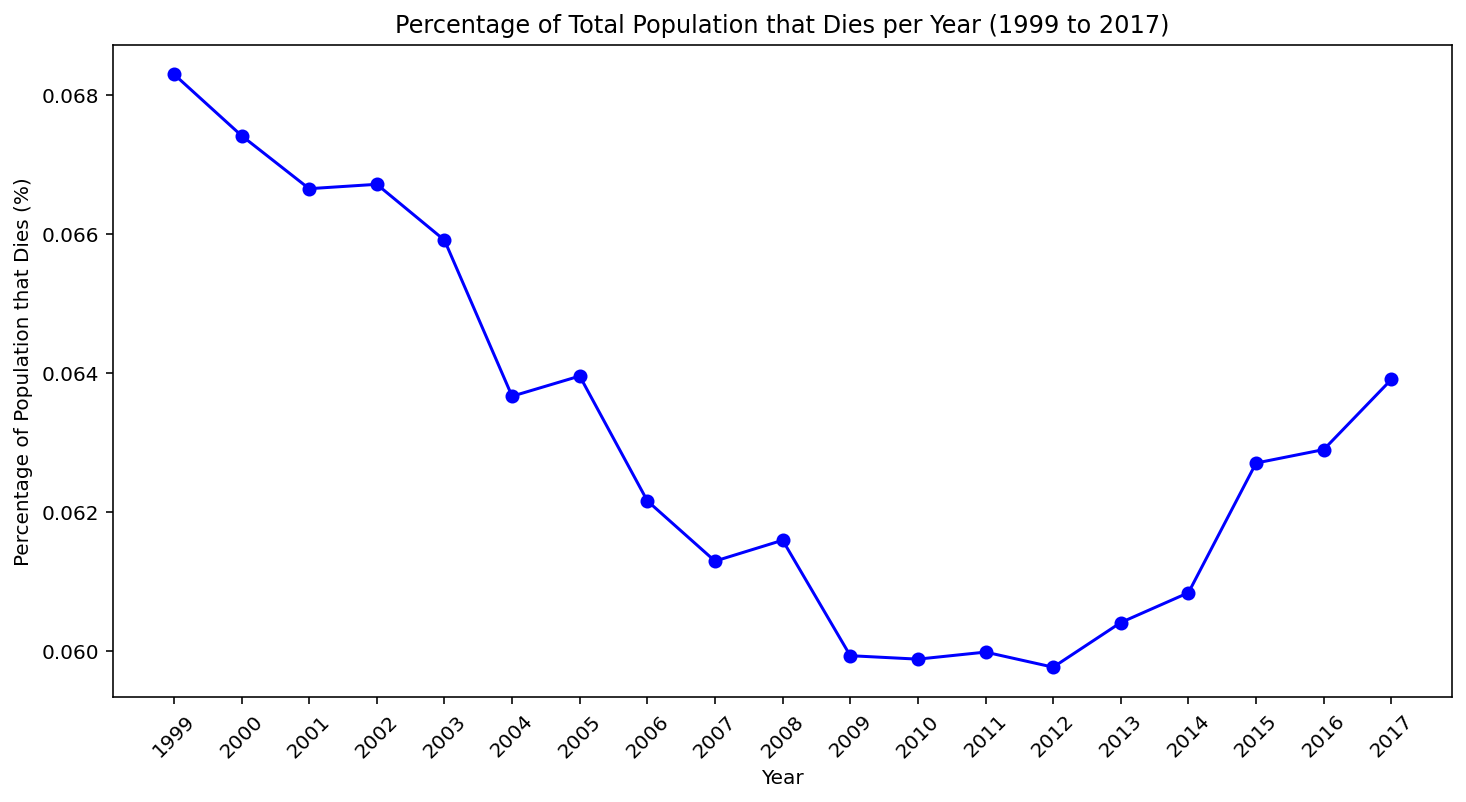

In [11]:
# Now aggregating 'core_and_state_pops' deaths by year
aggregate_2 = core_and_state_pops.groupby(['Year'])[['Deaths', 'Population']].sum().reset_index()

# Filtering for the years 1999 to 2017
population_growth = aggregate_2[(aggregate_2['Year'] >= 1999) & (aggregate_2['Year'] <= 2017)]

# Calculate percent of population that dies each year
death_percentage = (population_growth['Deaths'] / population_growth['Population']) * 100

# Plotting the death percentage
plt.figure(figsize=(12, 6))
plt.plot(population_growth['Year'], death_percentage, marker='o', color='blue')
plt.title('Percentage of Total Population that Dies per Year (1999 to 2017)')
plt.xlabel('Year')
plt.ylabel('Percentage of Population that Dies (%)')
plt.xticks(population_growth['Year'].unique(), rotation=45)
plt.show()

The cumulative rate of death observed across the population shows the same worrysome trend that we identified earlier in the heart disease deaths: A marked decrease from 1999 to 2009, followed by a clear upward trend from that date on.

This was not the result we were expecting.

At this point, we realized that there was another data point that our visualizations thus far did not take into account: 

Age of death.

We debated adding  this data to our analysis, since "Age\-adjusted Death Rate" was an existing column in our data set, so we examined the data and found the following: 


In [12]:
core_deaths.tail()

,Year,Cause Name,State,Deaths,Age-adjusted Death Rate
10863,1999,Kidney disease,Virginia,1035,16.9
10864,1999,Kidney disease,Washington,278,5.2
10865,1999,Kidney disease,West Virginia,345,16.4
10866,1999,Kidney disease,Wisconsin,677,11.9
10867,1999,Kidney disease,Wyoming,30,6.8


Ultimately, we decided against including age of death in our study for two reasons:

1\- Initial examination of our data showed that "Age\-adjusted Death Rate" did not display the actual mean age of the deaths, as illustrated by Kidney disease having values of 5.2 for Washington and 6.8 for Wyoming in 2017.

2\- Even if we could have extrapolated the mean ages of death, we would then have needed additional data around life expectancy for those years.

This would have taken us away from out focus of understand the leading causes of death and their evolution across the years in the US, so we decided against it.



Equipped with this data, we then proceeded to run a linear regression on all causes of death and visualize them through scatterplots:


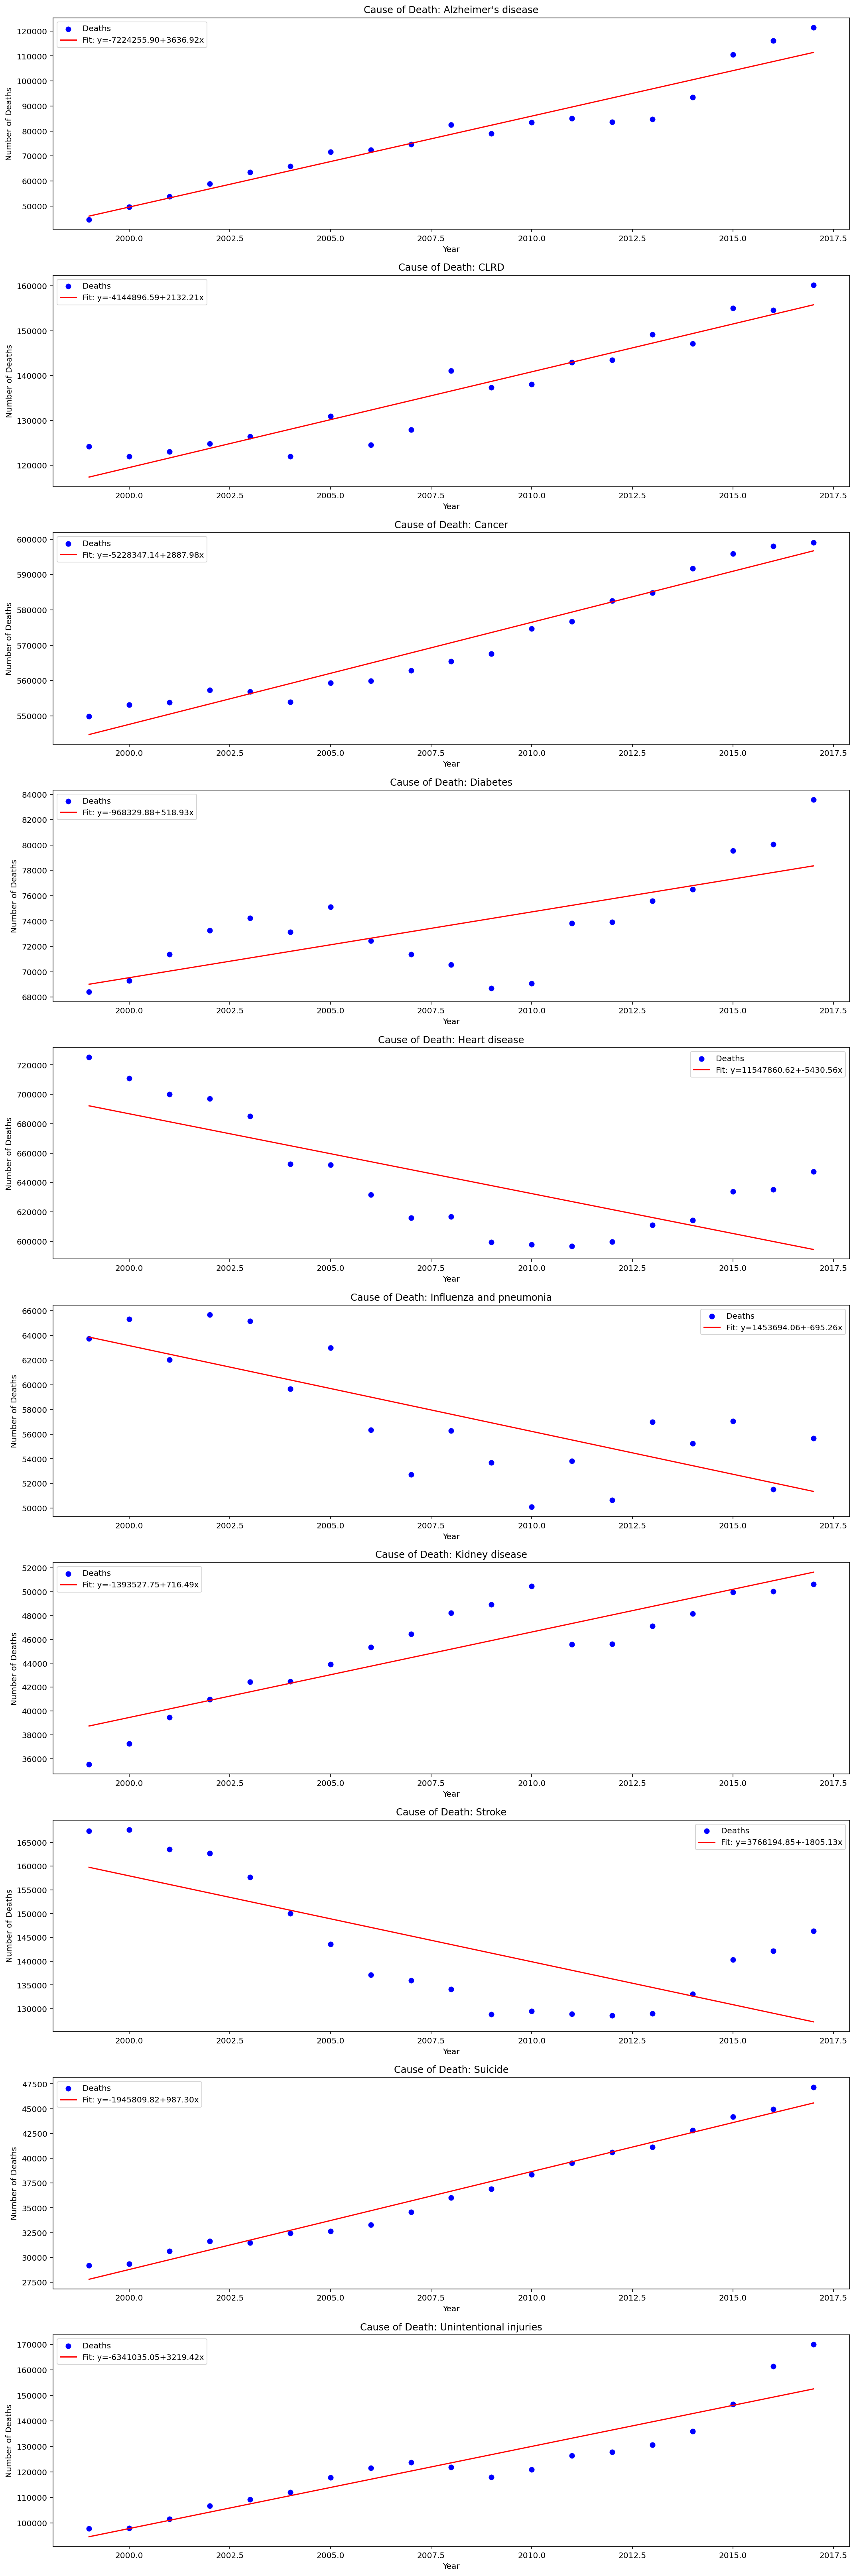

In [18]:
# Define 'causes' by extracting unique values from 'Cause Name' column
causes = aggregate['Cause Name'].unique()

# Plotting settings
plt.figure(figsize=(15, 45))

# Loop through each cause of death
for i, cause in enumerate(causes):
    # Filter data for the cause
    cause_data = aggregate[aggregate['Cause Name'] == cause]
    
    # Prepare data for regression
    X = cause_data[['Year']]
    y = cause_data['Deaths']
    
    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Get slope and intercept
    intercept = model.params['const']
    slope = model.params['Year']
    
    # Create scatter plot with regression line
    plt.subplot(len(causes), 1, i + 1)
    plt.scatter(cause_data['Year'], cause_data['Deaths'], color='blue', label='Deaths')
    
    # Regression line
    plt.plot(cause_data['Year'], intercept + slope * cause_data['Year'], color='red', label='Fit: y={:.2f}+{:.2f}x'.format(intercept, slope))
    
    # Labels and title
    plt.title(f'Cause of Death: {cause}')
    plt.xlabel('Year')
    plt.ylabel('Number of Deaths')
    plt.legend()

plt.tight_layout()
plt.show()

Initial observation of these plots made it evident that the linear regression model would be a great fit for some, but a very poor fit for others.  

In an ideal scenario, we would have been able to identify the best model fit for each cause of death.  

Given our actual time constraints however, this level of analysis was not viable.  

As such, we determined to learn and predict as much as we could from the data, relying exclusively on the linear regression model.



Our initial observations were as follow:

**Great Fits for the linear regression model:**

- CLRD: Appears to be a perfect fit.
- Suicide: A near\-perfect fit.
- Cancer: Also a great fit.

**Good Fits:**

- Alzheimer's: At first glance a good fit, though higher variation in the later years might prove this incorrect.
- Kidney Disease: Overall, a rather good fit.

**Average Fits:**

- Unintentional injuries: A good fit, though a spike in later years could throw off predictions

**Poor Fits:**

- Diabetes: Seems like a poor fit.
- Influenza: Rather poor fit, due to significant variation.

**Fits so bad the trend line appears headed in the wrong direction:**

- Heart Disease: No fit. The slope is negative whereas the deaths have been increasing for the last 5 years.
- Stroke: Again, the slope contradicts the last several years of data.



After this initial visual inspection, we decided to qualify our model fits more precisely by running an OLS Regression on the different trend lines.  In order to do so, we found it necessary to create a new dataframe to make the data more accessible \- We wanted the individual causes of death as column names, and we also needed to replace any spaces in those column names with underscores.


In [14]:
# Creating the 'Numbers_df' dataframe to get the causes of death as individual columns.
# To do so, Pivoting the 'aggregate' DataFrame:
Numbers_df = aggregate.pivot(index='Year', columns='Cause Name', values='Deaths')

# Adding 'Year' as a column
Numbers_df.reset_index(inplace=True)

# Replace spaces in column names with underscores
Numbers_df.columns = Numbers_df.columns.str.replace(' ', '_').str.replace("'", "")

# Display the new DataFrame
Numbers_df.head()

Cause Name,Year,Alzheimers_disease,CLRD,Cancer,Diabetes,Heart_disease,Influenza_and_pneumonia,Kidney_disease,Stroke,Suicide,Unintentional_injuries
0,1999.0,44536,124181,549838,68399,725192,63730,35525,167366,29199,97860
1,2000.0,49558,122009,553091,69301,710760,65313,37251,167661,29350,97900
2,2001.0,53852,123013,553768,71372,700142,62034,39480,163538,30622,101537
3,2002.0,58866,124816,557271,73249,696947,65681,40974,162672,31655,106742
4,2003.0,63457,126382,556902,74219,685089,65163,42453,157689,31484,109277


Now we were ready to continue, so we ran an OLS analysis on all variables, to measure for fit using R\-squared and AIC:



In [17]:
# Suppressing the warning for kurtosis calculations due to smaple size being too small.
warnings.filterwarnings("ignore")

# Listing dependent variables (Y columns)
dependent_vars = ['Alzheimers_disease', 'CLRD', 'Cancer', 'Diabetes', 'Heart_disease','Influenza_and_pneumonia', 'Kidney_disease', 'Stroke', 'Suicide', 'Unintentional_injuries'] 

# Looping through each dependent variable and running OLS
for y_col in dependent_vars:
    y = Numbers_df[y_col]
    X = Numbers_df[['Year']]  
    X = sm.add_constant(X)  
    
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    
    print(f"OLS Regression Results for {y_col}:")
    print(model.summary())
    print("\n" + "="*80 + "\n")

OLS Regression Results for Alzheimers_disease:
                            OLS Regression Results                            
Dep. Variable:     Alzheimers_disease   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     219.4
Date:                Sat, 15 Feb 2025   Prob (F-statistic):           3.78e-11
Time:                        07:44:18   Log-Likelihood:                -190.75
No. Observations:                  19   AIC:                             385.5
Df Residuals:                      17   BIC:                             387.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

This done, we then revisited our initial visual observations and matched them to the R\-Squared and AIC Scores:

**Great Fits:**

- CLRD: Appears to be a perfect fit.
  - R\-squared: 0.906
  - AIC:            370.8
- Suicide: A near\-perfect fit.
  - R\-squared: 0.978
  - AIC:            312.9
- Cancer: Also a great fit.
  - R\-squared: 0.940
  - AIC:            373.1

**Good Fits:**

- Alzheimer's: At first glance a good fit, though higher variation in the later years might prove this incorrect.
  - R\-squared:  0.928
  - AIC:             385.5
- Kidney Disease: Overall, a rather good fit.
  - R\-squared:  0.802
  - AIC:             345.8

**Average Fits:**

- Unintentional injuries: A good fit, though a spike in later years could throw off predictions
  - R\-squared:  0.864
  - AIC:             394.4

**Poor Fits**:

- Diabetes: Seems like a poor fit.
  - R\-squared:  0.508
  - AIC:              359.5
- Influenza: Rather poor fit, due to significant variation.
  - R\-squared:   0.573
  - AIC:              365.6

**Fits so bad the trend line appears headed in the wrong direction:**

- Heart Disease: No fit. The slope is negative whereas the deaths have been increasing for the last 5 years.
  - R\-squared:  0.542
  - AIC:             446.1
- Stroke: Again, the slope contradicts the last several years of data.
  - R\-squared:  0.525
  - AIC:             405.6



**A few interesting finds from this analysis:**

1 \- Our visual inspection findings were greatly confirmed by the R\-squared values, which almost matched our ranking estimates 1:1.

2 \- The AIC numbers for Diabetes and Influenza were much lower than expected, given their low R\-squared numbers. 



**The Final R\-squared ranking of Causes of Death, by best fit to this model:**

1 \- Suicide \(0.978\)

2 \- Cancer \(0.940\)

3 \- Alzheimer's \(0.928\)

4 \- CLRD \(0.906\)

5 \- Unintentional injuries \(0.864\)

6 \- Kidney Disease \(0.802\)

7\- Influenza \(0.573\)

8\- Heart Disease \(0.542\)

9\- Stroke \(0.525\)

10\- Diabetes \(0.508\)


With this in mind, we then ran our predictions.  

We had initially intended to predict numbers of deaths for 2024, but quickly found out that those tallies are not yet avaiable.  The most recent year with reliable death counts for the US is 2022, so we ran our predictions with that year as target


Cause of Death: Alzheimers_disease
  Slope: 3636.92
 2022 prediction: 129591.37
----------------------------------------


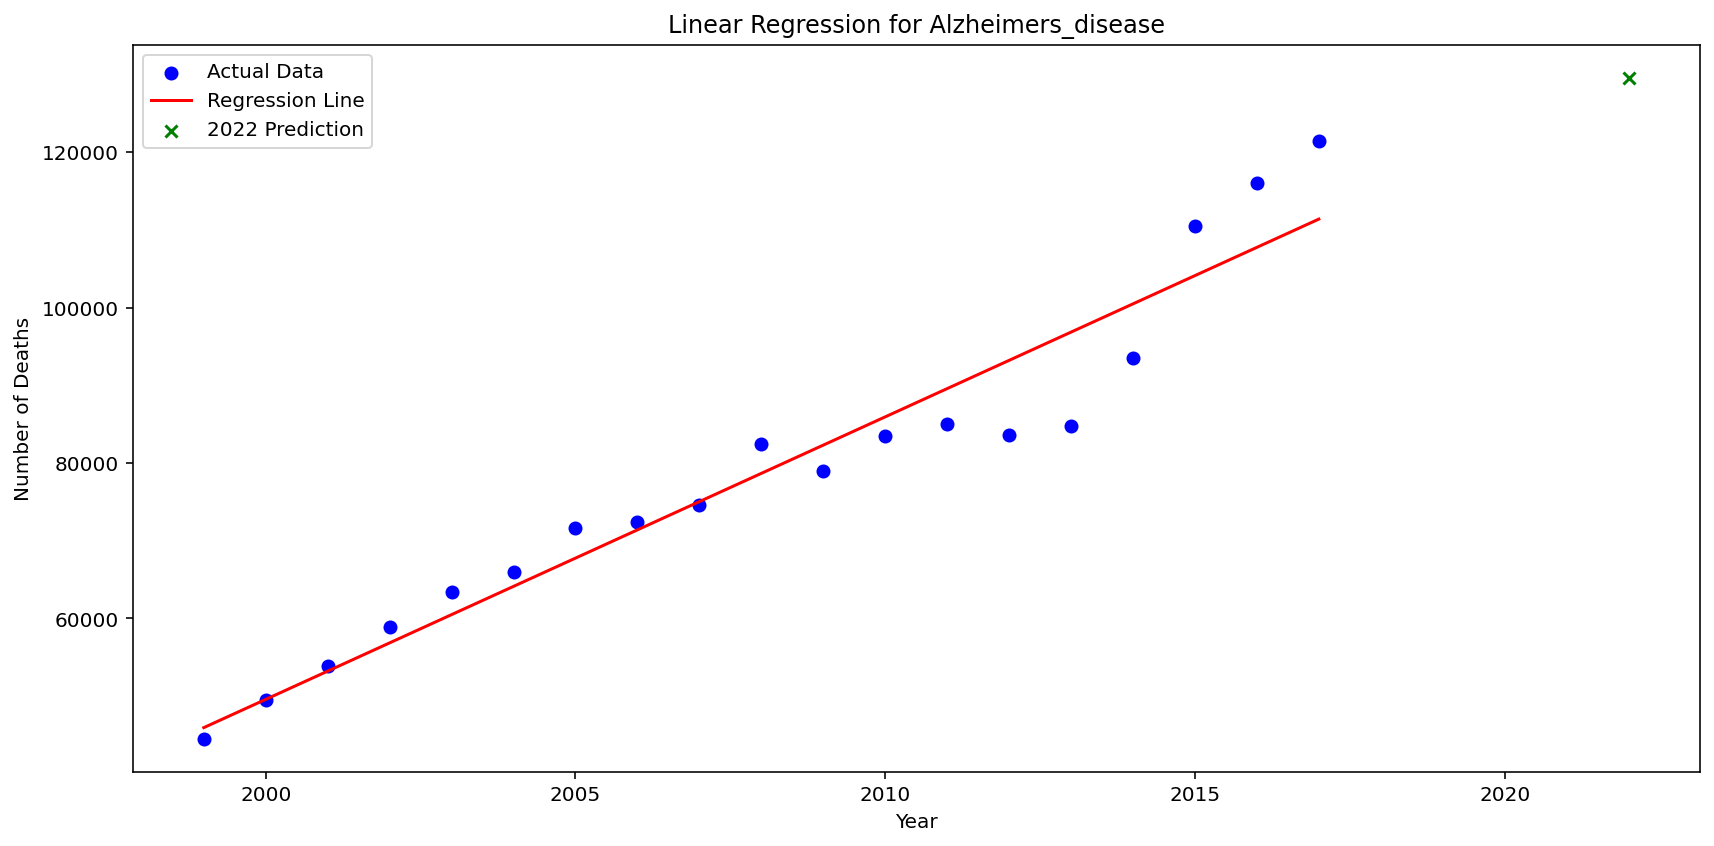

Cause of Death: CLRD
  Slope: 2132.21
 2022 prediction: 166426.00
----------------------------------------


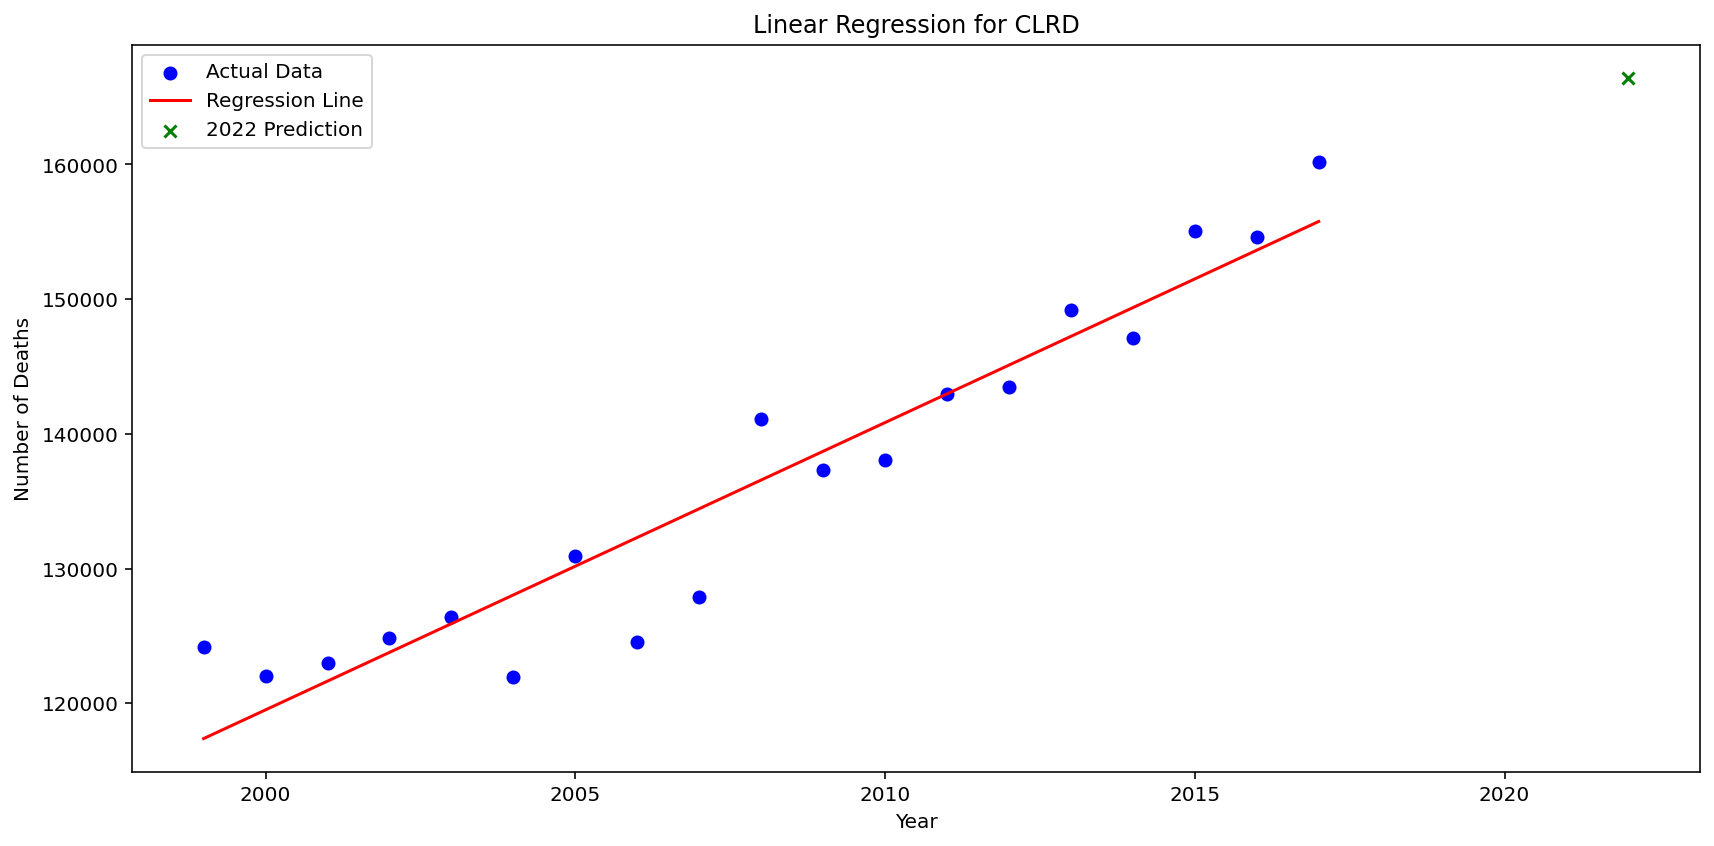

Cause of Death: Cancer
  Slope: 2887.98
 2022 prediction: 611149.84
----------------------------------------


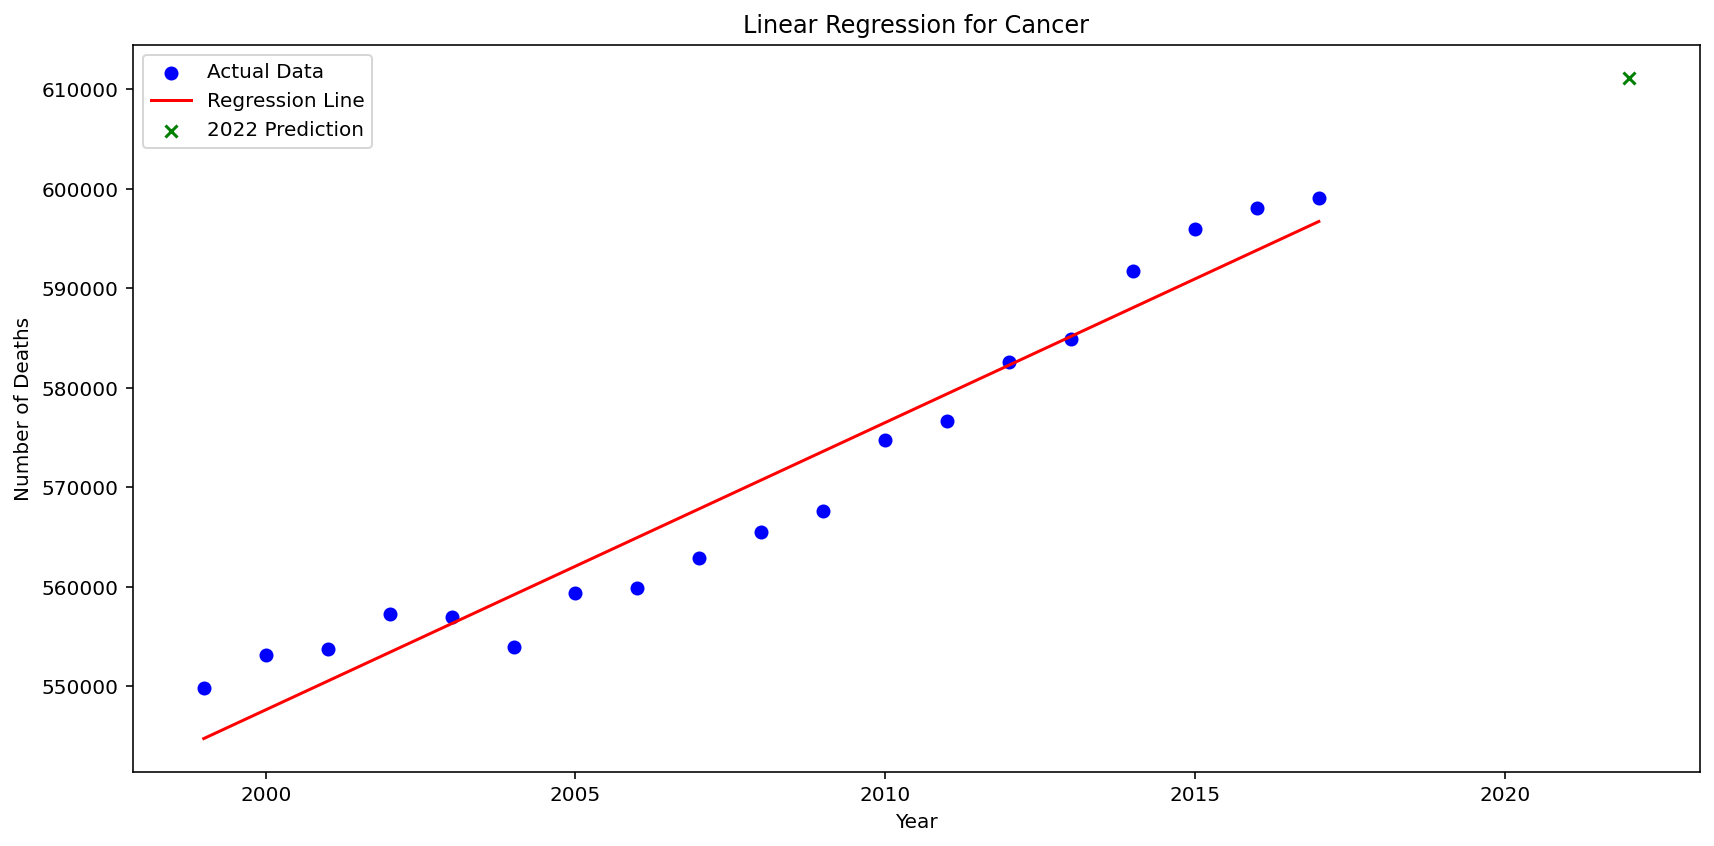

Cause of Death: Diabetes
  Slope: 518.93
 2022 prediction: 80946.23
----------------------------------------


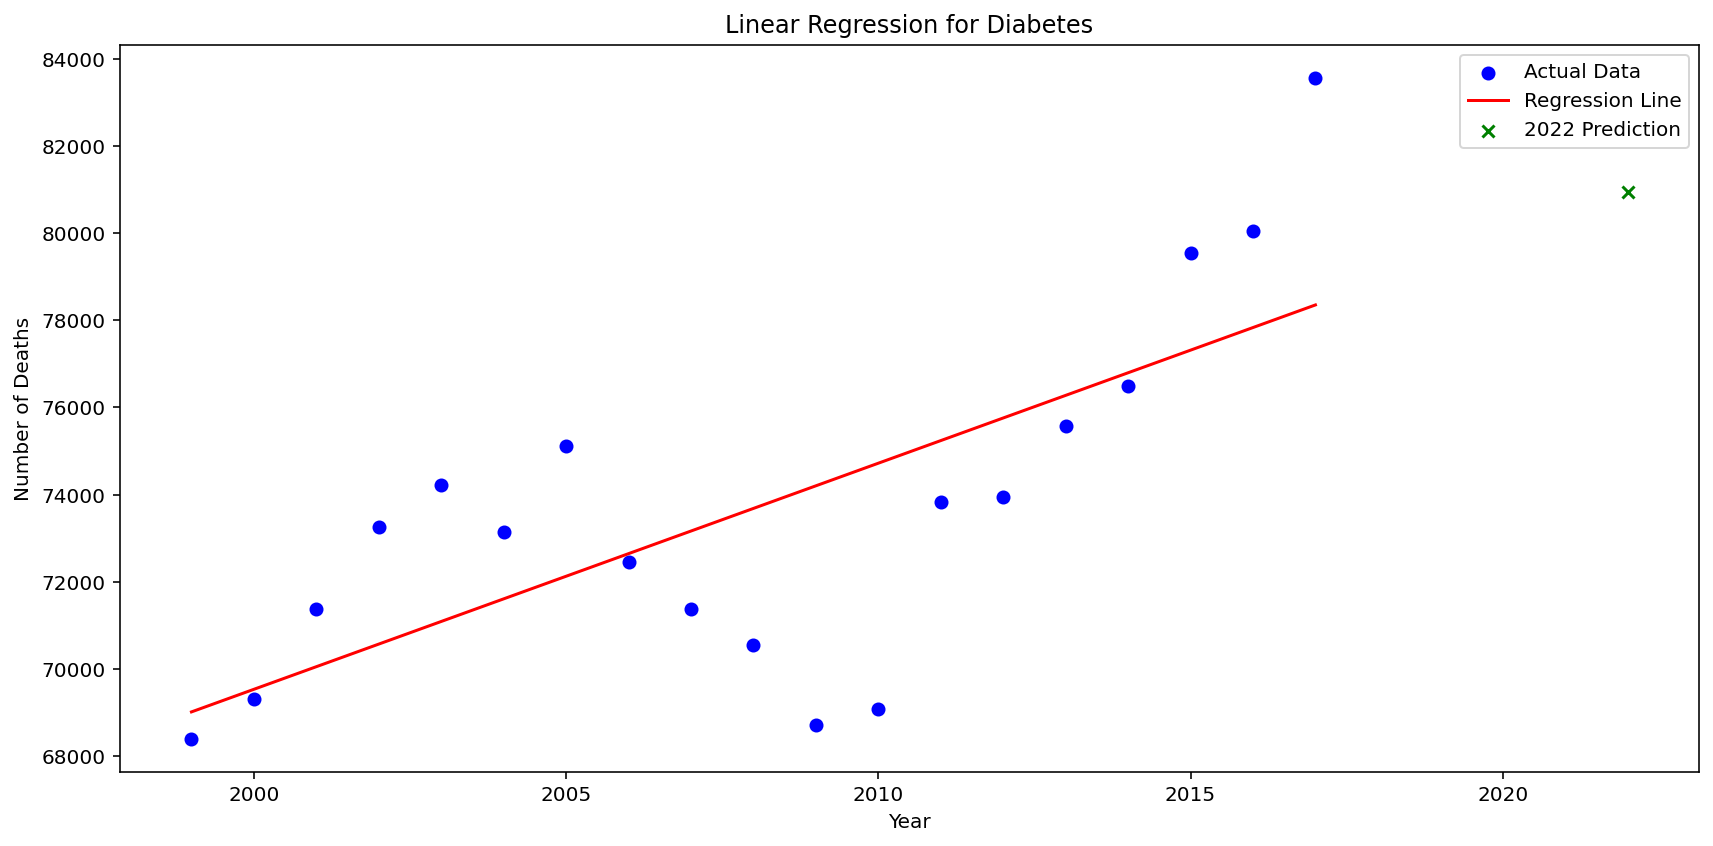

Cause of Death: Heart_disease
  Slope: -5430.56
 2022 prediction: 567269.01
----------------------------------------


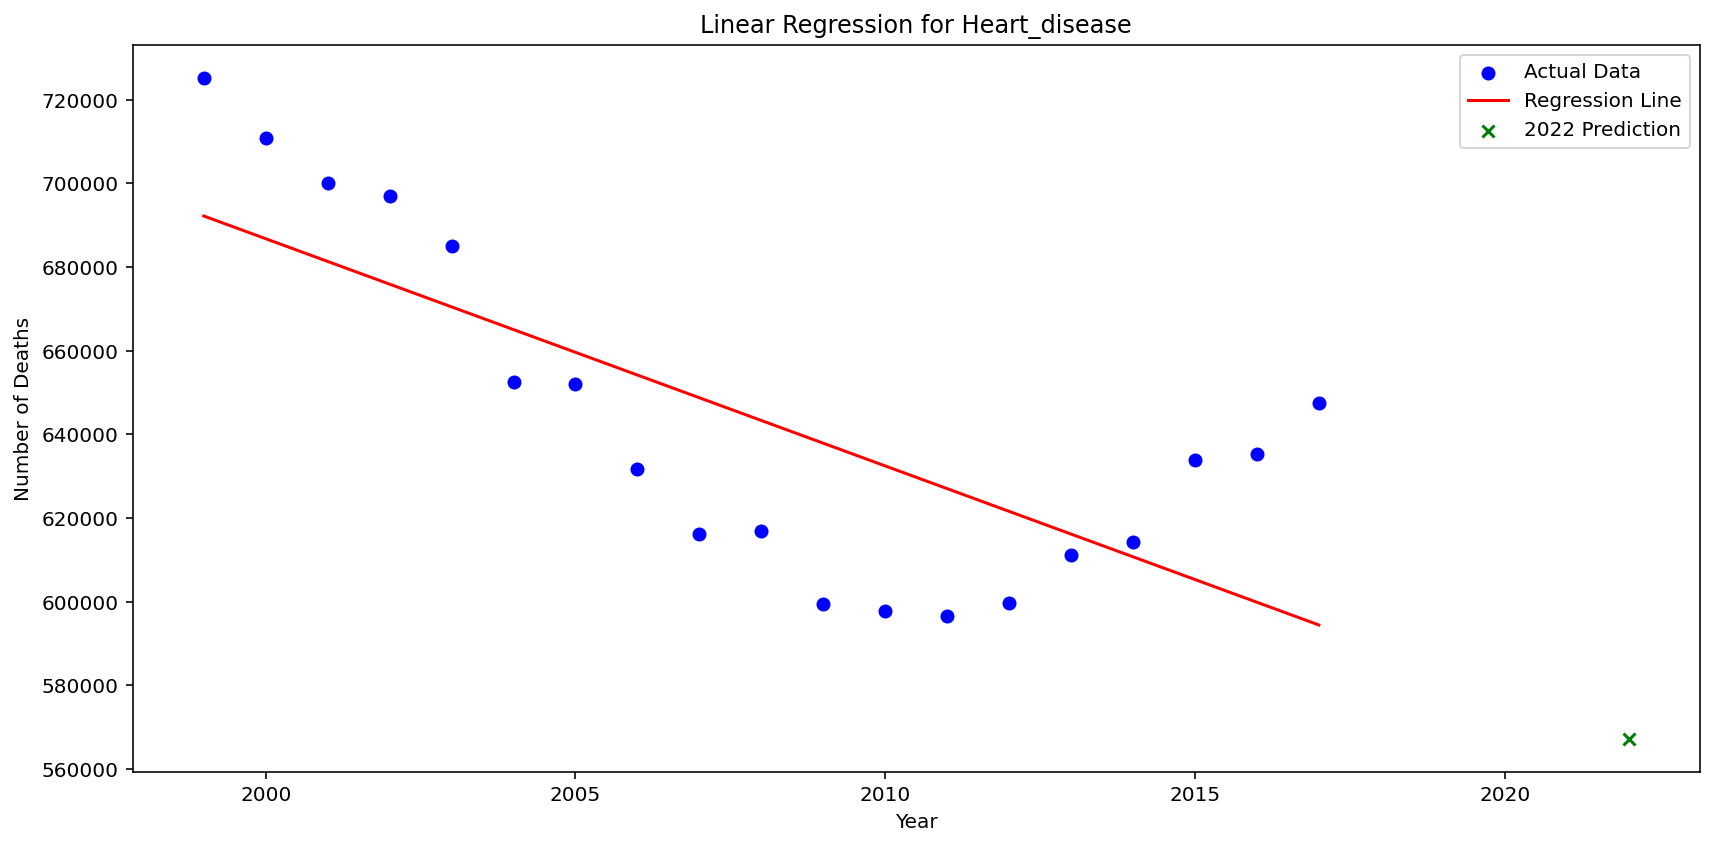

Cause of Death: Influenza_and_pneumonia
  Slope: -695.26
 2022 prediction: 47879.05
----------------------------------------


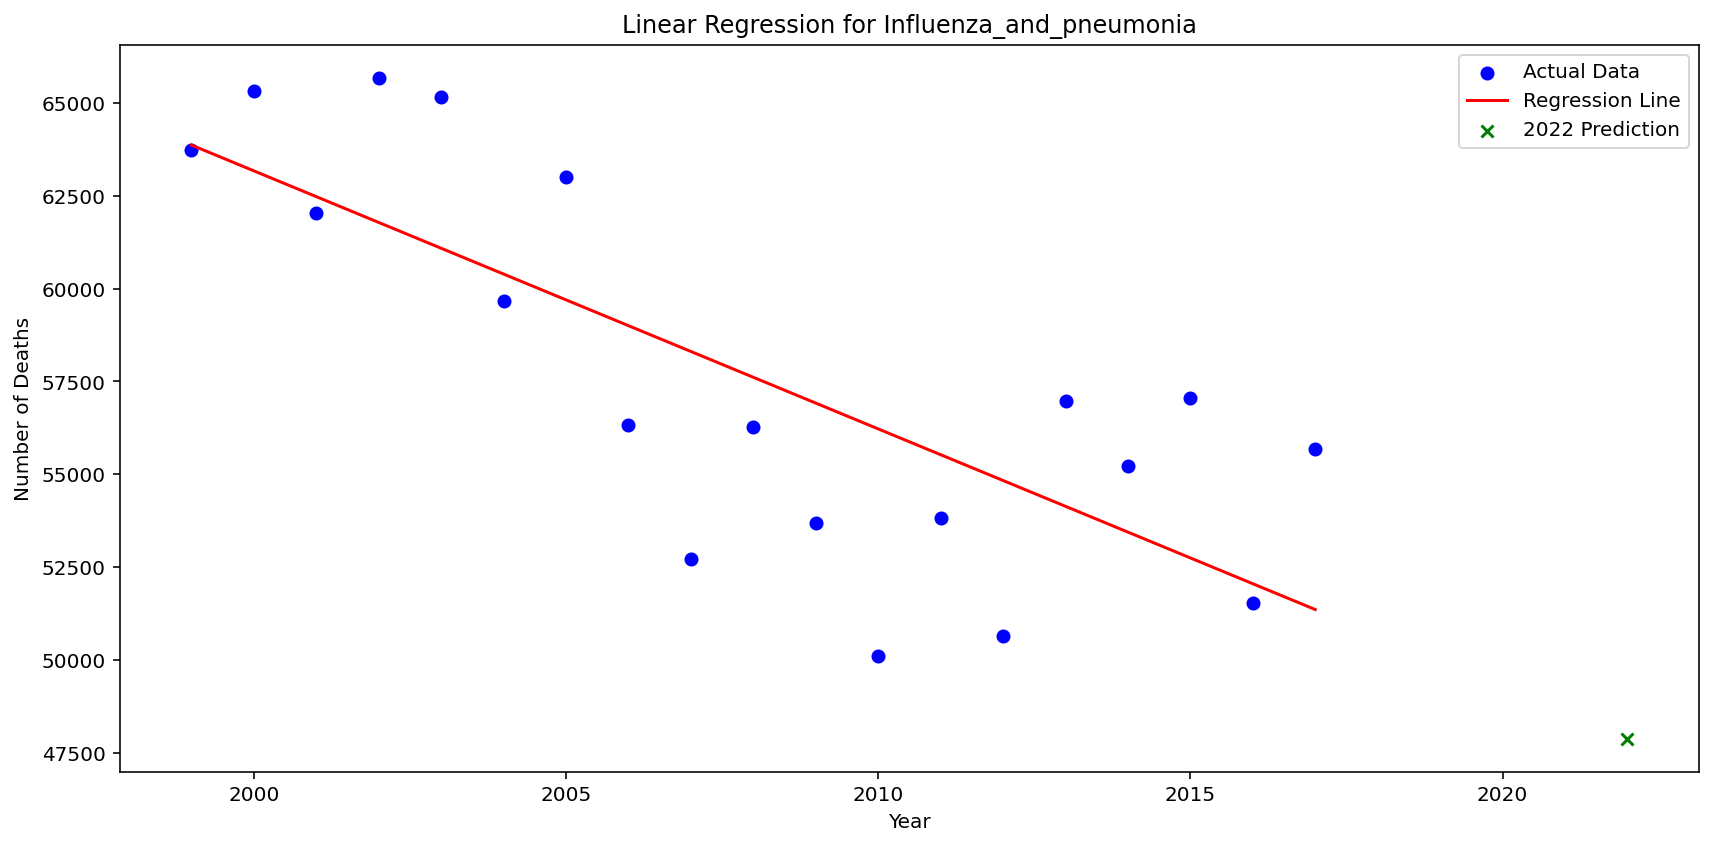

Cause of Death: Kidney_disease
  Slope: 716.49
 2022 prediction: 55221.06
----------------------------------------


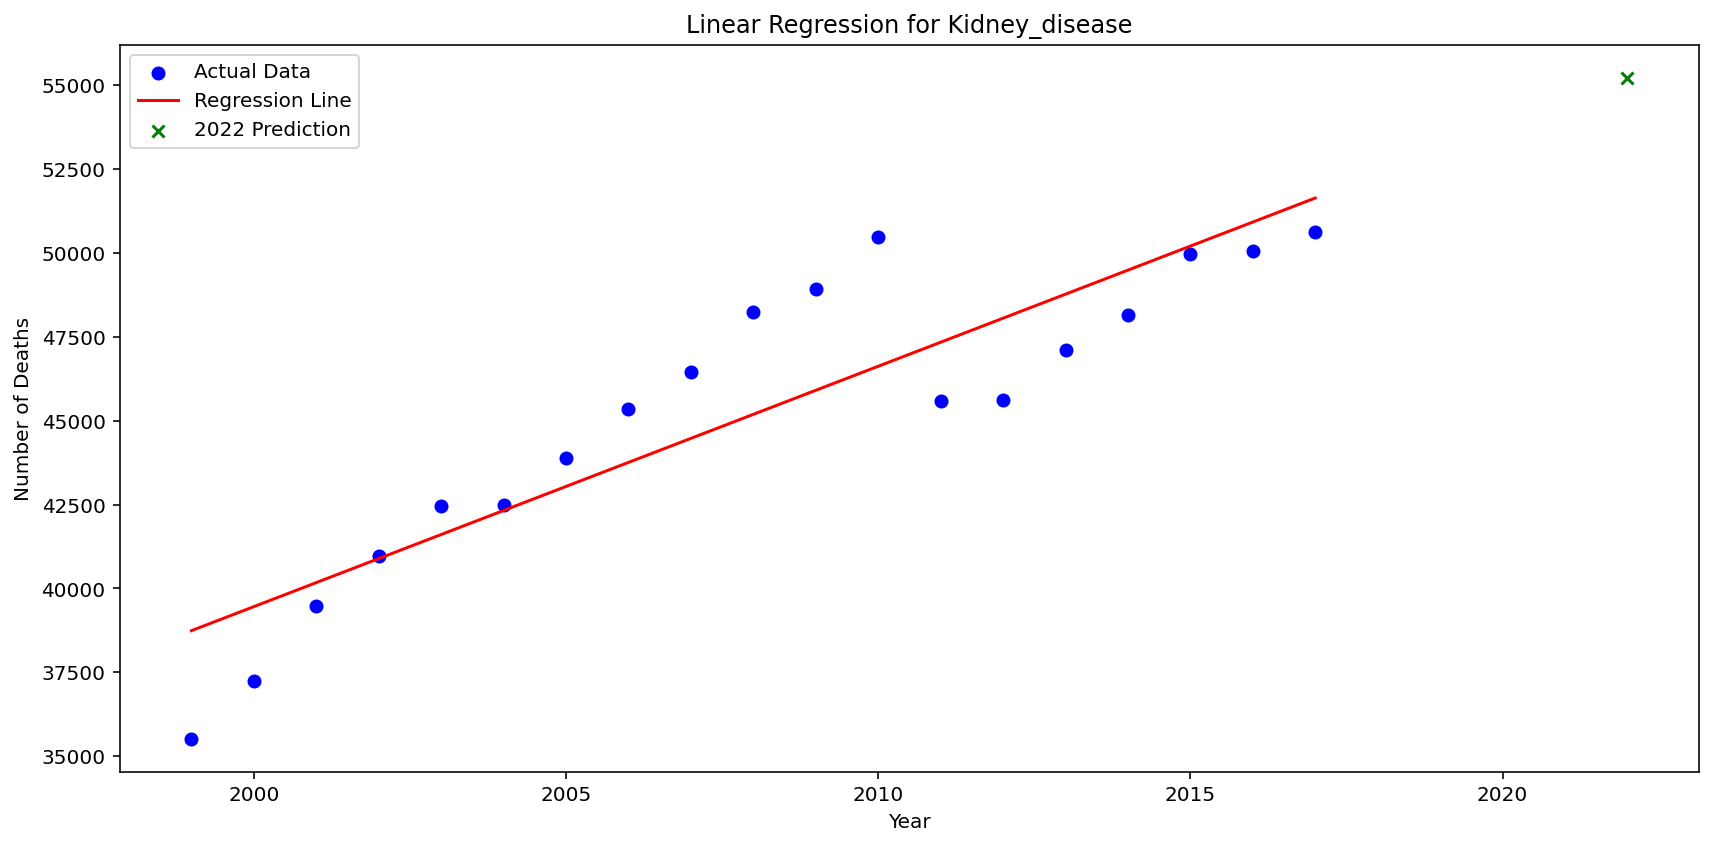

Cause of Death: Stroke
  Slope: -1805.13
 2022 prediction: 118229.44
----------------------------------------


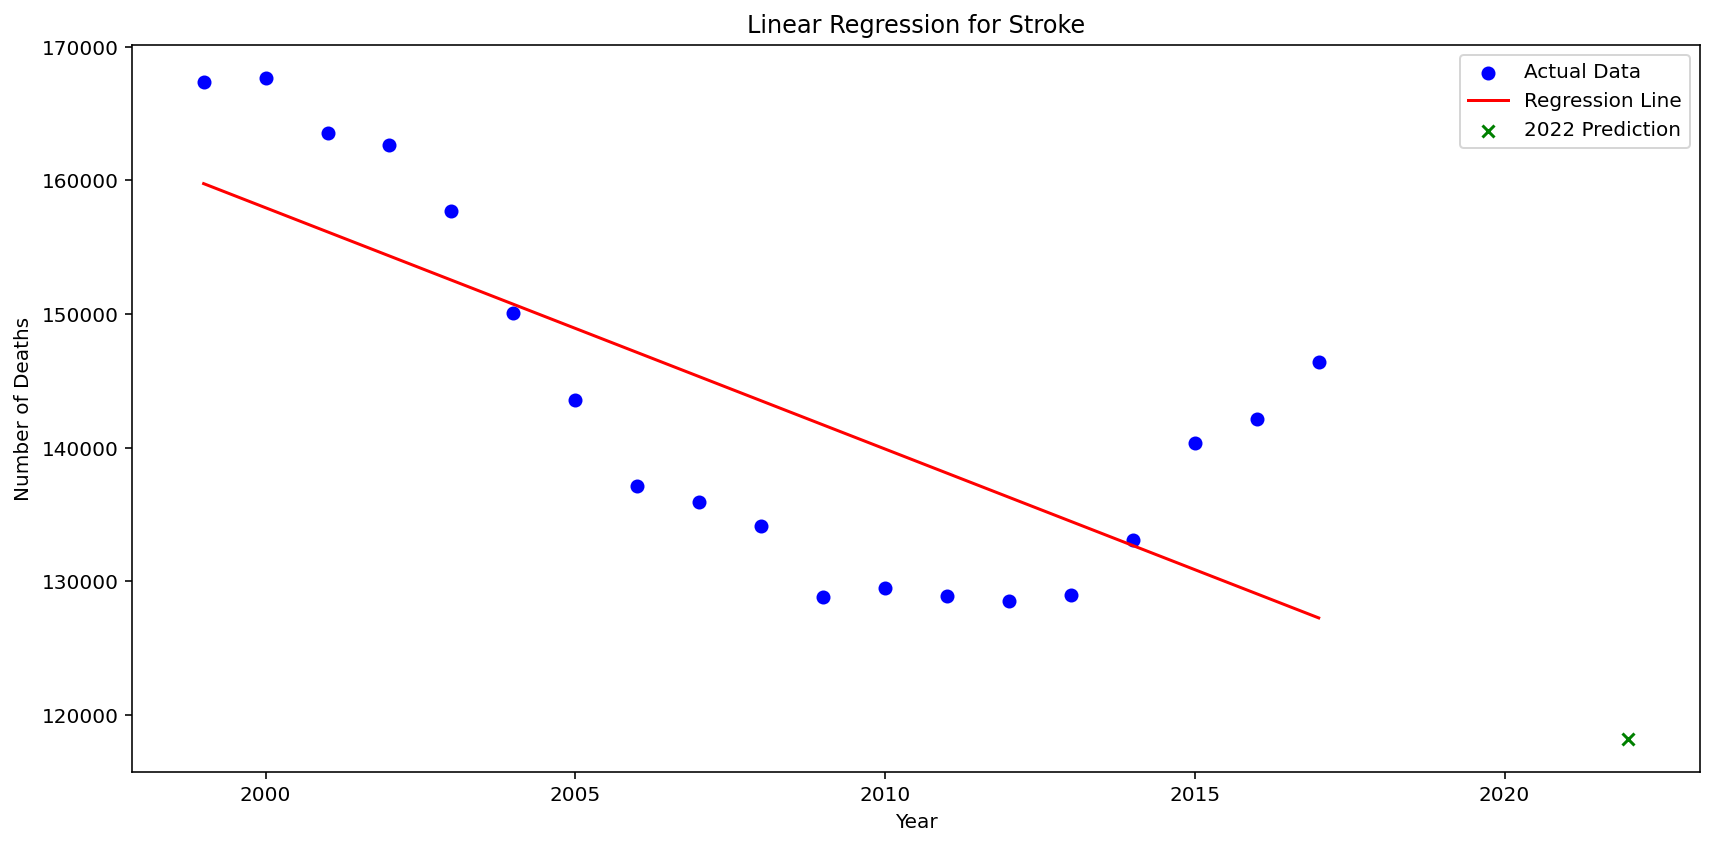

Cause of Death: Suicide
  Slope: 987.30
 2022 prediction: 50507.23
----------------------------------------


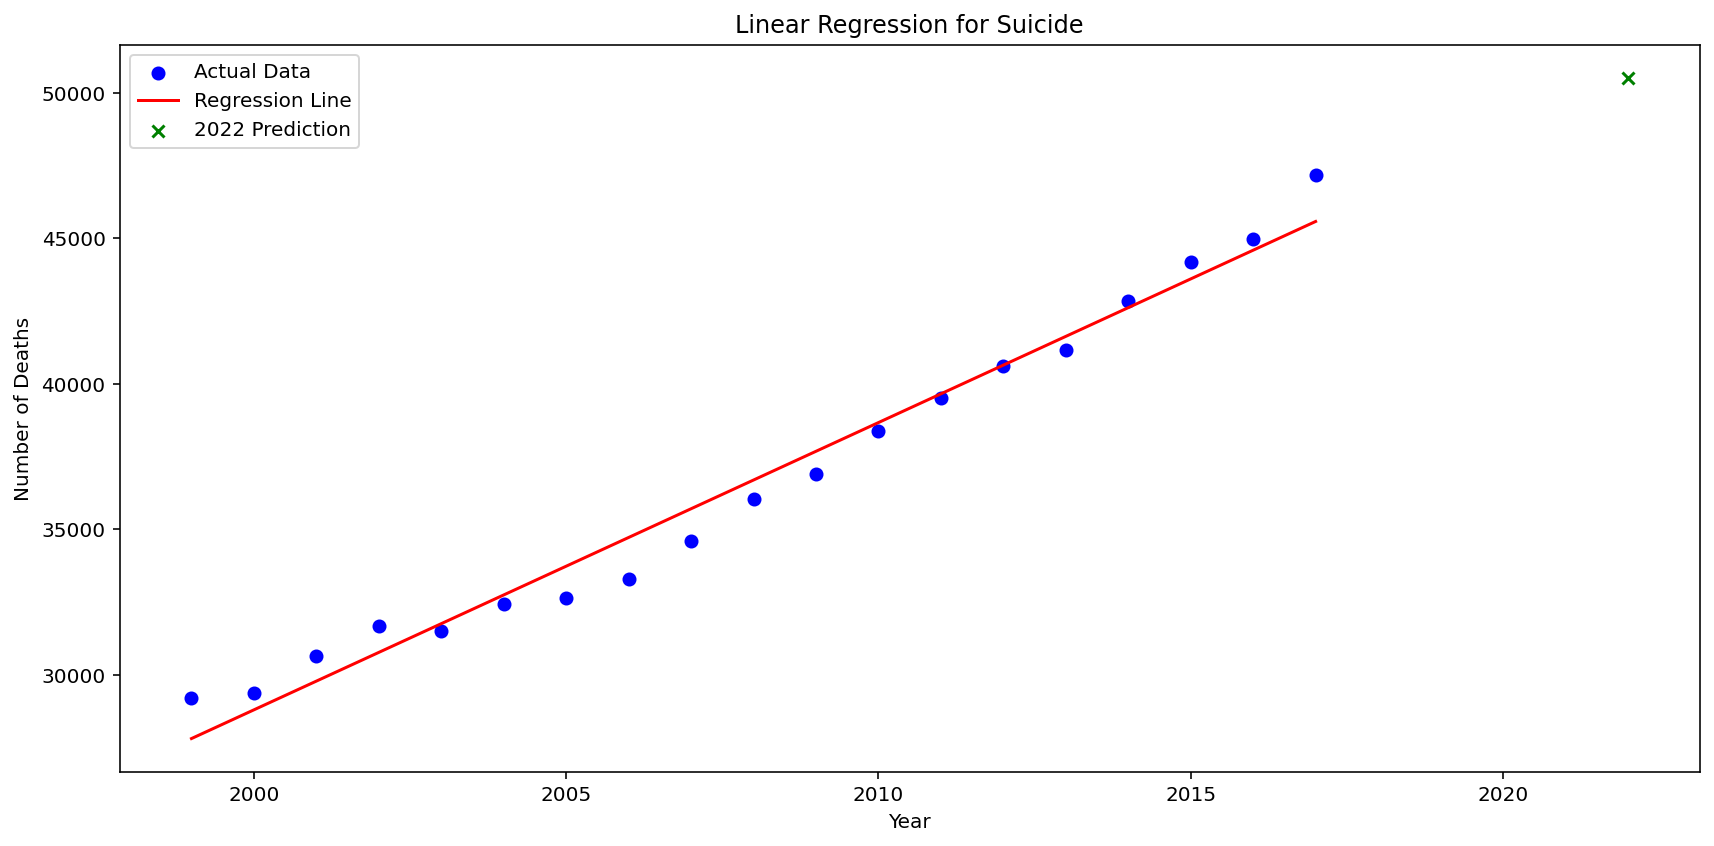

Cause of Death: Unintentional_injuries
  Slope: 3219.42
 2022 prediction: 168641.42
----------------------------------------


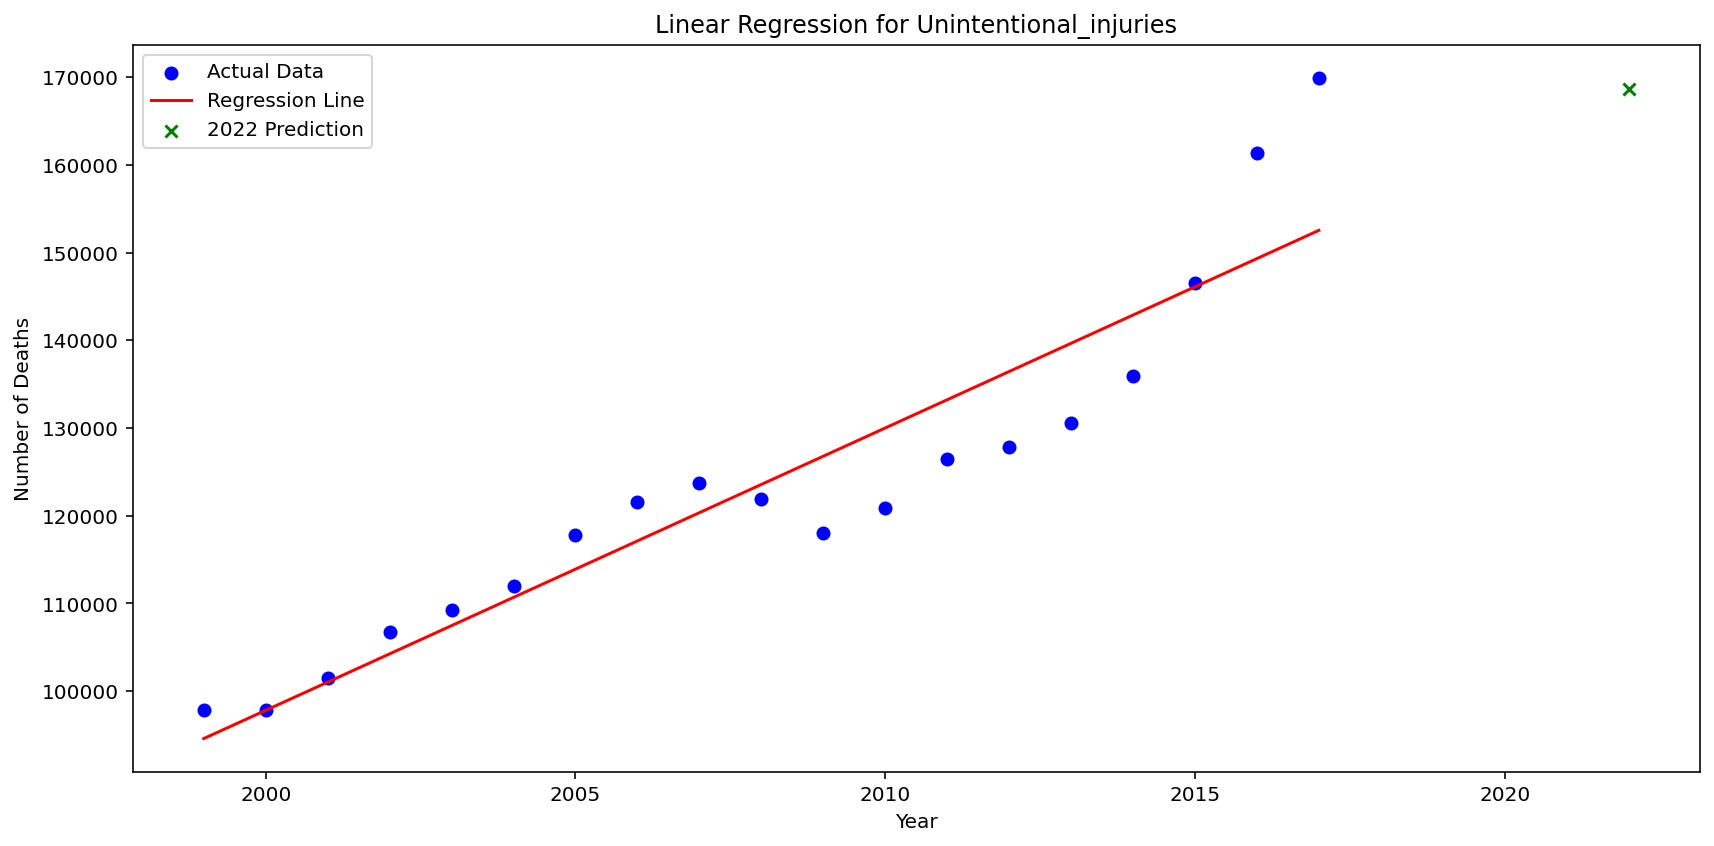

In [19]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Define which future years you'd like to predict:
future_years = [2022]  # Example future years

# Convert them to a NumPy array and reshape to match scikit-learn's expected input
X_future = np.array(future_years).reshape(-1, 1)

# We'll store predictions in a dictionary for convenience:
predictions = {}

for cause in Numbers_df.columns[1:]:  # skip the 'Year' column
    # Prepare the feature (Year) and target (Number of Deaths) arrays
    X = Numbers_df[['Year']]        # 2D DataFrame or array
    y = Numbers_df[cause].values    # 1D array

    # Create and train the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get the slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_

    # Predict existing data for plotting a regression line
    y_pred_line = model.predict(X)

    # Predict future values
    y_future = model.predict(X_future)

    # Store predictions in a dictionary
    predictions[cause] = {
        'slope': slope,
        'intercept': intercept,
        'future_years': future_years,
        'future_predictions': y_future
    }

    # Print model details
    print(f"Cause of Death: {cause}")
    print(f"  Slope: {slope:.2f}")
    for year, pred_val in zip(future_years, y_future):
        print(f" {year} prediction: {pred_val:.2f}")
    print("-" * 40)

    # Plot the original data and regression line (optional)
    plt.figure(figsize=(12,6))
    plt.scatter(X, y, label='Actual Data', color='blue')
    plt.plot(X, y_pred_line, label='Regression Line', color='red')
    plt.scatter(X_future, y_future, label='2022 Prediction', color='green', marker='x')
    plt.title(f"Linear Regression for {cause}")
    plt.xlabel("Year")
    plt.ylabel("Number of Deaths")
    plt.legend()
    plt.tight_layout()
    plt.show()

The expectation was that the causes of death which were good fits for the linear regression model would be fairly accurate in predicting 2022 deaths, whereas the causes that were not a good fit would be much further off target.


With our predictions in hand, we were all set to compare our predictions for 2022 with the actual data!
